### Import the necessary libraries

In [1]:
import sys

sys.path.append('../../') # add root folder project path

In [2]:
import os
import warnings
import itertools
import pickle 
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from base.plot_graphs import plot_confusion_matrix, plot_normalized_confusion_matrix, plot_roc_curve, plot_ecdf

from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

np.random.seed(10)

import multiprocessing

# check number of processors on current machine
print("Number of CPUs on current machine: %d" % multiprocessing.cpu_count())

# select the processor to be used (comment if processors >= 4)
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

Number of CPUs on current machine: 40


### Get preprocessed data (241 samples)

In [3]:
X = pickle.load(open( "../../data/preprocessed/article-genetic-data-features.p", "rb"))
y = pickle.load(open( "../../data/preprocessed/article-genetic-data-labels.p", "rb"))

print(type(X), " | ", X.shape)
print(type(y), " | ", len(y))

<class 'pandas.core.frame.DataFrame'>  |  (241, 1309)
<class 'pandas.core.series.Series'>  |  241


### Get best params from parameter tuning

In [4]:
bestparams_dt = pickle.load(open( "./best-params/dt-gridsearch-params.p", "rb"))
bestparams_rf = pickle.load(open( "./best-params/rf-gridsearch-params.p", "rb"))
bestparams_svc = pickle.load(open( "./best-params/svc-gridsearch-params.p", "rb"))
bestparams_gbm = pickle.load(open( "./best-params/gbm-gridsearch-params.p", "rb"))
bestparams_xgb = pickle.load(open( "./best-params/xgb-gridsearch-params.p", "rb"))

### Create function to be used to perform model fitting using LOOCV 

In [5]:
def fit_model(model, X, y):  
    # prepare a LOOCV object (number of folds equals the number of samples)
    loocv = LeaveOneOut()
    loocv.get_n_splits(X)
    
    # perform cross-validation and get the accuracies
    cv_score = cross_val_score(model, X, y, cv=loocv, scoring='accuracy') 
    
    # perform cross-validation and get the predictions and prediction probabilities
    preds = cross_val_predict(model, X, y, cv=loocv)
    predprobs_responsive = cross_val_predict(model, X, y, cv=loocv, method='predict_proba')[:,1]
    predprobs_refractory = cross_val_predict(model, X, y, cv=loocv, method='predict_proba')[:,0]
    
    # calculate fpr and tpr values using the y_true and predictions probabilities
    fpr, tpr, _ = metrics.roc_curve(y, predprobs_responsive)
    
    # calculate the auc score based on fpr and tpr values
    auc_score = metrics.auc(fpr, tpr)

    # generate the confusion matrix for the model results and slice it into four pieces
    cm = metrics.confusion_matrix(y, preds)
    TP, TN, FP, FN = cm[1, 1], cm[0, 0], cm[0, 1], cm[1, 0]
    
    # print model information
    print(model)

    # print classification report
    print("\nAccuracy (CV Score) : Mean - %.7g | Std - %.7g" % (np.mean(cv_score), np.std(cv_score)))
    print("\nAUC Score : %f" % auc_score)
    
    # calculate sensitivity score
    # specificity: When the actual value is negative, how often is the prediction correct?
    # how "specific" (or "selective") is the classifier in predicting positive instances?
    specificity = TN / float(TN + FP)
    print("\nSpecificity Score : %f" % specificity)
    
    # calculate sensitivity score
    # sensitivity: When the actual value is positive, how often is the prediction correct?
    # how "sensitive" is the classifier to detecting positive instances? Also known as "True Positive Rate" or "Recall"
    sensitivity = TP / float(TP + FN)
    print("\Sensitivity Score : %f" % sensitivity)
    
    # print a complete classification metrics report
    print("\n" + metrics.classification_report(y, preds)) 
    
    # get current model name
    model_name = str(model).split('(')[0]
    
    # generate plots
    plot_confusion_matrix(cm, model_name, 'loocv-bestparams-genetic')
    plot_normalized_confusion_matrix(cm, model_name, 'loocv-bestparams-genetic') 
    plot_roc_curve(fpr, tpr, auc_score, model_name, 'loocv-bestparams-genetic')
    
    return predprobs_responsive, predprobs_refractory, preds, fpr, tpr, auc_score 

### Create a DecisionTreeClassifier model using the found best parameters

In [ ]:
bestparams_dt['random_state'] = 10
bestparams_dt

In [ ]:
dt = DecisionTreeClassifier(**bestparams_dt)

# perform model fitting
dt_predprobs_responsive, dt_predprobs_refractory, dt_preds, fpr_dt, tpr_dt, auc_dt = fit_model(dt, X, y)

# export values
pickle.dump(dt_predprobs_responsive, open("../predictions/dt-loocv-bestparams-genetic-predprobs.p", "wb"))
pickle.dump(dt_preds, open("../predictions/dt-loocv-bestparams-genetic-preds.p", "wb"))

### Create a RandomForestClassifier model using the found best parameters

In [ ]:
bestparams_rf['random_state'] = 10
bestparams_rf

In [ ]:
rf = RandomForestClassifier(**bestparams_rf)

# perform model fitting
rf_predprobs_responsive, rf_predprobs_refractory, rf_preds, fpr_rf, tpr_rf, auc_rf = fit_model(rf, X, y)

# export values
pickle.dump(rf_predprobs_responsive, open("../predictions/rf-loocv-bestparams-genetic-predprobs.p", "wb"))
pickle.dump(rf_preds, open("../predictions/rf-loocv-bestparams-genetic-preds.p", "wb"))

### Create a SVM model using the found best parameters

In [ ]:
bestparams_svc['probability'] = True
bestparams_svc['random_state'] = 10

bestparams_svc

In [ ]:
svc = SVC(**bestparams_svc)

# perform model fitting
svc_predprobs_responsive, svc_predprobs_refractory, svc_preds, fpr_svc, tpr_svc, auc_svc = fit_model(svc, X, y)

# export values
pickle.dump(svc_predprobs_responsive, open("../predictions/svc-loocv-bestparams-genetic-predprobs.p", "wb"))
pickle.dump(svc_preds, open("../predictions/svc-loocv-bestparams-genetic-preds.p", "wb"))

### Create a GBM using the found best parameters

In [8]:
bestparams_gbm['random_state'] = 10

bestparams_gbm

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 250,
 'random_state': 10}

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=10,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Accuracy (CV Score) : Mean - 0.813278 | Std - 0.3896882

AUC Score : 0.868964

Specificity Score : 0.925926
\Sensitivity Score : 0.582278

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       162
           1       0.79      0.58      0.67        79

   micro avg       0.81      0.81      0.81       241
   macro avg       0.81      0.75      0.77       241
weighted avg       0.81      0.81      0.80

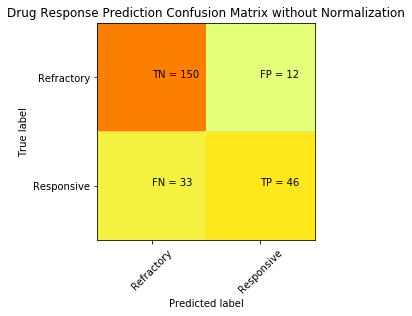

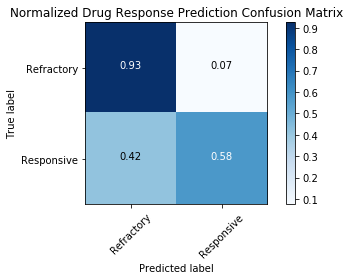

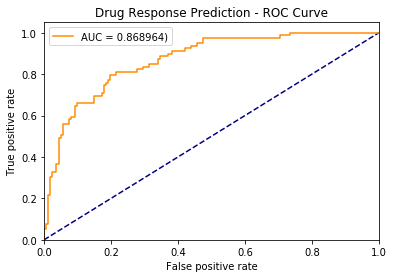

In [9]:
gbm = GradientBoostingClassifier(**bestparams_gbm)

# perform model fitting
gbm_predprobs_responsive, gbm_predprobs_refractory, gbm_preds, fpr_gbm, tpr_gbm, auc_gbm = fit_model(gbm, X, y)

# export values
pickle.dump(gbm_predprobs_responsive, open("../predictions/gbm-loocv-bestparams-genetic-predprobs.p", "wb"))
pickle.dump(gbm_preds, open("../predictions/gbm-loocv-bestparams-genetic-preds.p", "wb"))

### Create a XGB baseline model using default parameters

In [ ]:
bestparams_xgb['random_state'] = 10

bestparams_xgb

In [ ]:
xgb = XGBClassifier(**bestparams_xgb)

# ignore deprecation warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# perform model fitting
xgb_predprobs_responsive, xgb_predprobs_refractory, xgb_preds, fpr_xgb, tpr_xgb, auc_xgb = fit_model(xgb, X, y)

# export values
pickle.dump(xgb_predprobs_responsive, open("../predictions/xgb-loocv-bestparams-genetic-predprobs.p", "wb"))
pickle.dump(xgb_preds, open("../predictions/xgb-loocv-bestparams-genetic-preds.p", "wb"))

### Compare all generated ROC curves

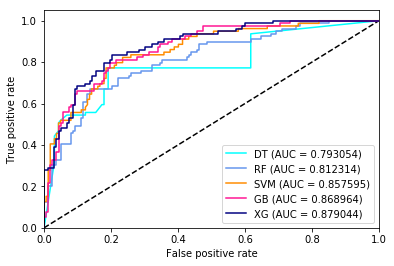

In [5]:
# get prediction probabilities from individual classifiers
dt_predprobs = pickle.load( open( "../predictions/dt-loocv-bestparams-genetic-predprobs.p", "rb" ) )
rf_predprobs = pickle.load( open( "../predictions/rf-loocv-bestparams-genetic-predprobs.p", "rb" ) )
svc_predprobs = pickle.load( open( "../predictions/svc-loocv-bestparams-genetic-predprobs.p", "rb" ) )
gbm_predprobs = pickle.load( open( "../predictions/gbm-loocv-bestparams-genetic-predprobs.p", "rb" ) )
xgb_predprobs = pickle.load( open( "../predictions/xgb-loocv-bestparams-genetic-predprobs.p", "rb" ) )

# calculate fpr, tpr and auc score for all models using the y_true and its predictions probabilities
fpr_dt, tpr_dt, _ = metrics.roc_curve(y, dt_predprobs)
auc_dt = metrics.auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y, rf_predprobs)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

fpr_svc, tpr_svc, _ = metrics.roc_curve(y, svc_predprobs)
auc_svc = metrics.auc(fpr_svc, tpr_svc)

fpr_gbm, tpr_gbm, _ = metrics.roc_curve(y, gbm_predprobs)
auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)

fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y, xgb_predprobs)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

# plot all roc curves into the same image
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')  , 
plt.plot(fpr_dt, tpr_dt, color='aqua', label='DT (AUC = %f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, color='cornflowerblue', label='RF (AUC = %f)' % auc_rf)
plt.plot(fpr_svc, tpr_svc, color='darkorange', label='SVM (AUC = %f)' % auc_svc)
plt.plot(fpr_gbm, tpr_gbm, color='deeppink', label='GB (AUC = %f)' % auc_gbm)
plt.plot(fpr_xgb, tpr_xgb, color='navy', label='XG (AUC = %f)' % auc_xgb)
plt.xlabel('False positive rate') # False positive rate
plt.ylabel('True positive rate') # True positive rate
# plt.title('Comparison of ROC curves of ') # Drug Response Prediction - ROC Curve
plt.legend(loc='lower right')
# save plot as image 
plt.savefig('../figures/roc-curves/loocv-bestparams-genetic-models-comparison-roc-curves-v2.pdf', dpi=300)
plt.show()

### Plot the ECDF (empirical cumulative distribution function) of the best model

#### PS: XGBoost is the best classifier, but if its results can not be loaded, Gradient Boosting is the second best classifier

In [10]:
predprobs_responsive, predprobs_refactory = gbm_predprobs_responsive, gbm_predprobs_refractory

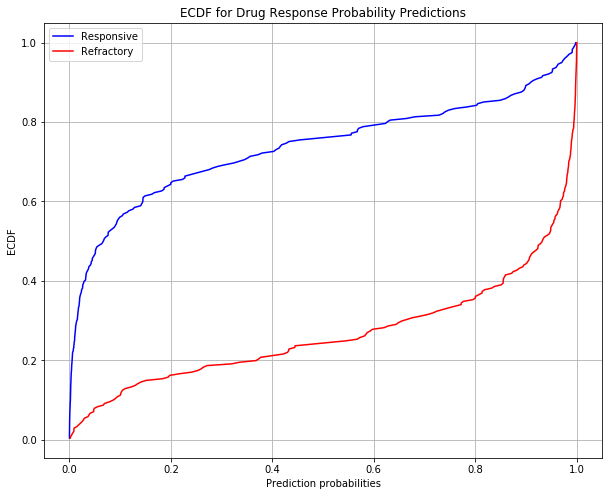

In [11]:
plot_ecdf(predprobs_responsive, predprobs_refactory)